
Z-cut LN: TE mode use No,and TM mode use Ne
Total height : 600
bottom height: 100
top width : 600-2100nm, steps 100nm
side-wall angle: 70 degree
sio2 bottom cladding
Pulse: 10mW, 200MHz

- Propagation loss ?
- mode selection - TE or TM?

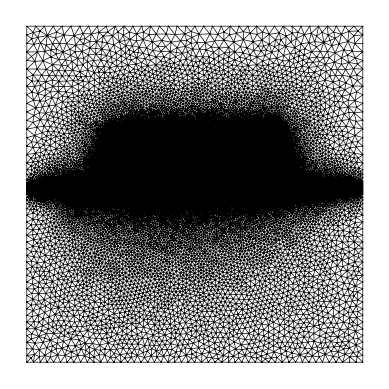

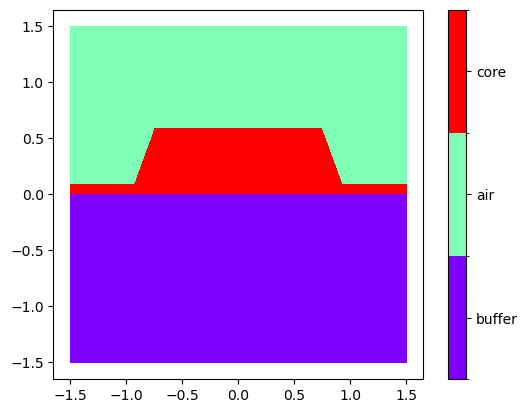

start


  0%|          | 0/1 [00:00<?, ?it/s]

sort by TE fraction


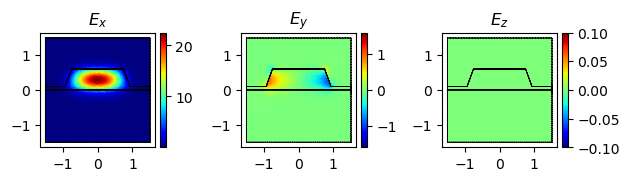

sort by neff


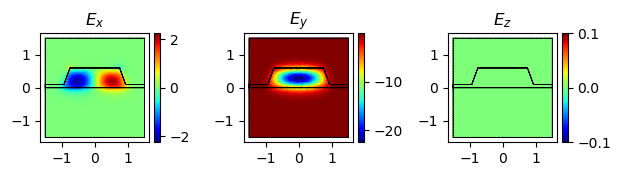

sort by TM fraction


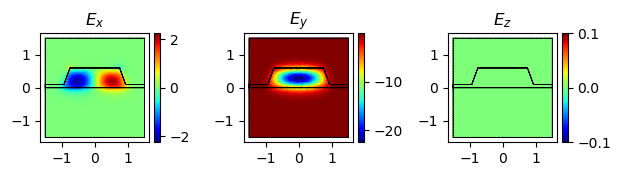

  0%|          | 0/1 [00:00<?, ?it/s]

sort by TE fraction


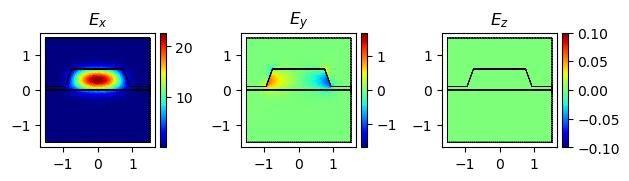

sort by neff


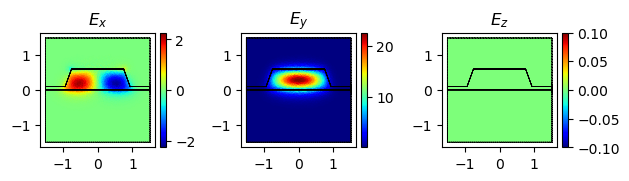

sort by TM fraction


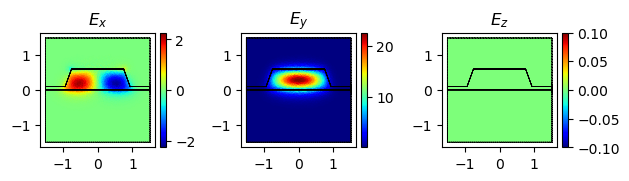

100%|██████████| 1/1 [00:22<00:00, 22.90s/it]


In [5]:
import math
from skfem import Basis, ElementTriP0
from tqdm import tqdm
from femwell.mesh import mesh_from_OrderedDict
from skfem.io import from_meshio
from femwell.visualization import plot_domains
import shapely
from femwell.maxwell.waveguide import compute_modes
from SCG_Stimulation.Simulation.refractive_index import n_SiO2,n_LNOI,n_Air
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union

wavelength_range = [500, 2500]
wavelegnth_step = 70

# waveguide parameters
# bottom_width = 2 # um
top_width = [0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1]

top_width = 1.5

box_height = 3
triangle_height = 0.6
side_angle = 70
triangle_width = triangle_height / math.tan(side_angle * math.pi / 180)
bottom_height = 0.1

# Construct waveguide geometry
core_trapiz = Polygon(
    [(top_width / 2 + triangle_width, 0), (-top_width / 2 - triangle_width, 0), (-top_width / 2, triangle_height),
     (top_width / 2, triangle_height)])
bottom = shapely.geometry.box(-box_height / 2, 0, box_height / 2, bottom_height)
core = unary_union([core_trapiz, bottom])
buffer = shapely.geometry.box(-box_height / 2, -box_height / 2, box_height / 2, 0)
air = shapely.geometry.box(-box_height / 2, 0, box_height / 2, box_height / 2)

polygon = OrderedDict(
    core=core,
    buffer=buffer,
    air=air
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.01, "distance": 0.1},
                   buffer={"resolution": 0.06, "distance": 0.5},
                   air={"resolution": 0.08, "distance": 0.5})

mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions))
mesh.draw().show()
plot_domains(mesh)
plt.show()

# ----------------------FEM solver-------------------------------
print("start")
# Calculate dispersion and gamma
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = [1000]

for ray in ["o", "e"]:
    neff_list_te = []
    aeff_list_te = []
    neff_list_tm = []
    aeff_list_tm = []

    n_core = lambda w: n_LNOI(w, ray=ray)
    n_buffer = n_SiO2
    n_air = n_Air
    n_dict = {"core": n_core, "buffer": n_buffer, "air": n_air}
    
    for wavelength in tqdm(wavelength_list):
        
        wavelength = wavelength * 1e-3
        
        for subdomain, n in n_dict.items():
            epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2
        modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)
        
        ## te mode
        print("sort by TE fraction")
        modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.te_fraction))
        mode = modes_sorted[0]
        neff_list_te.append(np.real(mode.n_eff))
        aeff_list_te.append(mode.calculate_effective_area())
        mode.show(mode.E.real, direction = "x")
        
        ## sort by neff
        print("sort by neff")
        modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.n_eff))
        mode = modes_sorted[1]
        mode.show(mode.E.real, direction = "x")
        
        ## tm mode
        print("sort by TM fraction")
        modes_sorted = modes.sorted(key=lambda mode: -np.real(mode.tm_fraction))
        if modes_sorted[0].tm_fraction < 0.7:
            print(f"at {wavelength}um, mode has highest tm_fraction of f{modes_sorted[0].tm_fraction}")
        mode = modes_sorted[0]
        neff_list_tm.append(np.real(mode.n_eff))
        aeff_list_tm.append(mode.calculate_effective_area())
        mode.show(mode.E.real, direction = "x")

        
    neff_list_te = np.array(neff_list_te)
    aeff_list_te = np.array(aeff_list_te)
    neff_list_tm = np.array(neff_list_tm)
    aeff_list_tm = np.array(aeff_list_tm)
    wls = np.array(wavelength_list)




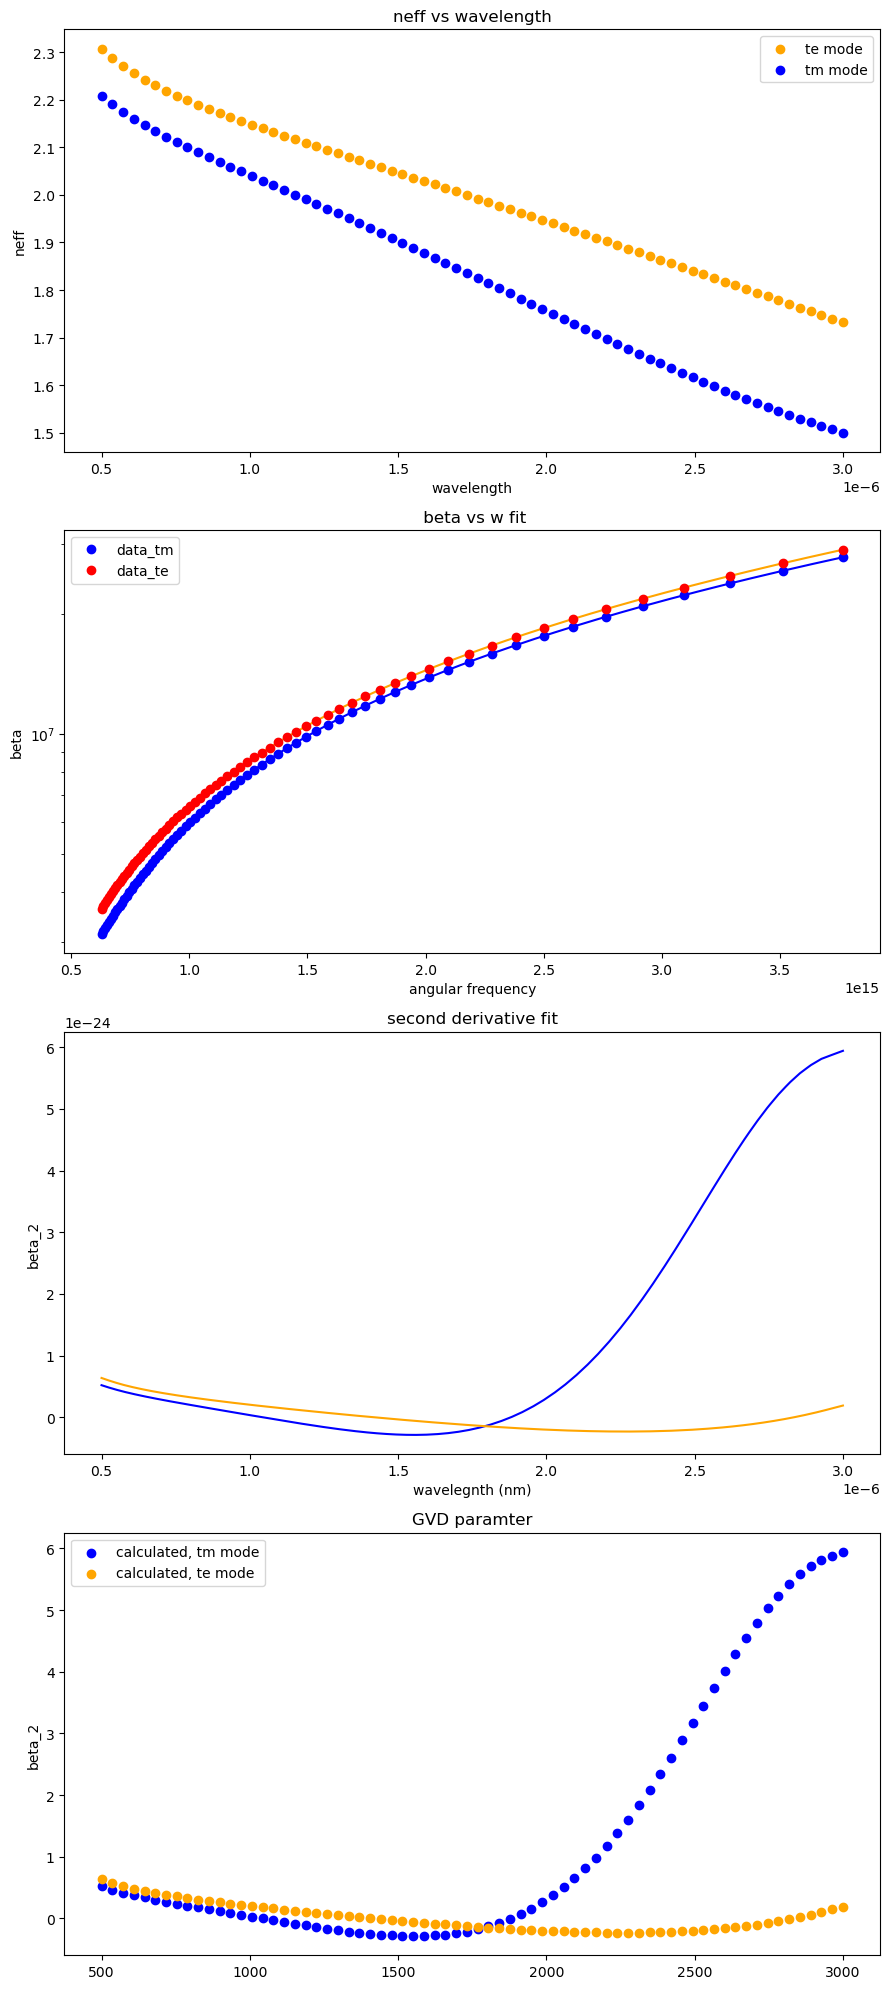

In [1]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from SCG_Stimulation.Simulation.refractive_index import n_SiO2,n_LNOI,n_Air
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c
import pandas as pd
top_width = 1.5

data_tm = np.load(f"data_w_{top_width}_e.npz")
data_te = np.load(f"data_w_{top_width}_o.npz")
neff_list_tm = np.array(np.real(data_tm['neff_list_tm']))
neff_list_te = np.array(np.real(data_te['neff_list_te']))

wls = np.linspace(500, 3000, 70)*1e-9
angular_freq =  lambda w:(c/ w) * 2 * np.pi
beta_tm = neff_list_tm * 2*np.pi/(wls)
beta_te = neff_list_te * 2*np.pi/(wls)

sorted_w = angular_freq(wls)[::-1]
sorted_beta_tm = beta_tm[::-1]
sorted_beta_te = beta_te[::-1]

fig, axs = plt.subplots(4, 1, figsize=(9,20))

#-----------fit neff spline----------------------------------
y_spl_tm = UnivariateSpline(sorted_w,sorted_beta_tm,s=0,k=3)
y_spl_te = UnivariateSpline(sorted_w,sorted_beta_te,s=0,k=3)

w_range = np.linspace(wls[0],wls[-1],1000)
x_range = angular_freq(w_range)


#-----------neff plot-----------------
axs[0].set_xlabel("wavelength")
axs[0].set_ylabel("neff")
axs[0].set_title("neff vs wavelength")
axs[0].scatter(wls,neff_list_te, color="orange", label = "te mode")
axs[0].scatter(wls,neff_list_tm, color="blue", label = "tm mode")
axs[0].legend()

#-----------beta plot-----------------
axs[1].set_xlabel("angular frequency")
axs[1].set_ylabel("beta")
axs[1].set_title(" beta vs w fit")
axs[1].semilogy(x_range,y_spl_tm(x_range), color="b")
axs[1].semilogy(x_range,y_spl_te(x_range), color="orange")
axs[1].semilogy(angular_freq(wls),beta_tm,'bo',label = 'data_tm')
axs[1].semilogy(angular_freq(wls),beta_te,'ro',label = 'data_te')
axs[1].legend()

#-----------beta_2 plot-----------------
y_spl_2d_tm = y_spl_tm.derivative(n=2)
y_spl_2d_te = y_spl_te.derivative(n=2)
axs[2].set_xlabel("wavelegnth (nm)")
axs[2].set_ylabel("beta_2")
axs[2].set_title("second derivative fit")

axs[2].plot(w_range,y_spl_2d_tm(x_range) , color="blue")
axs[2].plot(w_range,y_spl_2d_te(x_range) , color="orange")

#-----------beta_2 plot---------------------------
beta_2_tm = y_spl_2d_tm(angular_freq(wls)) * 1e24
beta_2_te = y_spl_2d_te(angular_freq(wls)) * 1e24

axs[3].scatter(wls * 1e9, beta_2_tm, label = "calculated, tm mode", c="blue")
axs[3].scatter(wls * 1e9, beta_2_te, label = "calculated, te mode", c="orange")

axs[3].set_ylabel("beta_2")
axs[3].set_title("GVD paramter")
axs[3].legend()

plt.tight_layout()
plt.show()